In [11]:
import numpy as np
import ast, dataIO, common_functions
from sklearn import cross_validation, linear_model, preprocessing, svm
from sklearn.grid_search import GridSearchCV
reload(dataIO)
reload(common_functions)

def get_touch_locations(userid):
    touches = []
    filenos = ["2", "6", "9"]
    
    for fileno in filenos:
        filename = "/home/dimitar/Desktop/Python/experiment/results/"+str(userid)+"_"+fileno+"up.txt"
        with open(filename, "r") as f:
            lines = f.read().splitlines()
            lines = map(lambda x: x.split('\t'), lines[1:])
            for line in lines:
                letter = line[1]
                location = ast.literal_eval(line[3])
                x = location[0]
                y = location[1]
                time = line[2]
                bod = dataIO.createlist(line[-1])
                if line[0] == "left":
                    touch = dataIO.Touch(x,y,bod,letter,time, True)
                else:
                    touch = dataIO.Touch(x,y,bod,letter,time, False)
                touches.append(touch)
        
    return touches


def run(userId):
    locations = get_touch_locations(userId)
    filtered = dataIO.filter_new(locations)
    
    centers = dataIO.get_key_centers()
    keys = centers.keys()
    
    touch_centers = []
    centers_l = []
    centers_r = []
    touches = []
    points = []
    
    points_l = []
    points_r = []
    bod_l = []
    bod_r = []
    t_l_x = []
    t_l_y = []
    t_r_x = []
    t_r_y = []
    
    for touch in filtered:
        center = centers[touch.letter]
        touch_centers.append(center)
        location = [touch.x, touch.y]        
        points.append(location)
        
        if touch.left:
            #points_l.append([touch.x, touch.y, touch.x**2, touch.y**2])
            points_l.append(location)
            centers_l.append(center)
            bod_l.append(touch.bod)
            t_l_x.append(center[0]-location[0])
            t_l_y.append(center[1]-location[1])
        else:
            #points_r.append([touch.x, touch.y, touch.x**2, touch.y**2])
            points_r.append(location)
            centers_r.append(center)
            bod_r.append(touch.bod)
            t_r_x.append(center[0]-location[0])
            t_r_y.append(center[1]-location[1])
                     
    
    centers_l = np.array(centers_l)
    centers_r = np.array(centers_r)
    touch_centers = np.array(touch_centers)
    points = np.array(points)
    points_l = np.array(points_l)
    points_r = np.array(points_r)
    bod_l = np.array(bod_l)
    bod_r = np.array(bod_r)
    t_l_x = np.array(t_l_x)
    t_l_y = np.array(t_l_y)
    t_r_x = np.array(t_r_x)
    t_r_y = np.array(t_r_y)
    
    points_unz = np.array(map(lambda x: list(x) , zip(*points))) 
    centers_unz = np.array(map(lambda x: list(x) , zip(*touch_centers)))
    
    print("MSE on x before regression: %.2f"
               % np.mean((points_unz[0] - centers_unz[0]) ** 2))
    
    print("MSE on y before regression: %.2f"
               % np.mean((points_unz[1] - centers_unz[1]) ** 2))
    
#     print("MSE on x before regression: %.2f"
#                % np.mean((np.concatenate((t_l_x, t_r_x))) ** 2))
    
#     print("MSE on y before regression: %.2f"
#                % np.mean((np.concatenate((t_l_y, t_r_y))) ** 2))
#     print
#     return
    
    foldno = 1
    mse_x = []
    mse_y = []
    within_before = []
    within_after = []
    kf_l = cross_validation.KFold(len(points_l), n_folds=5, shuffle=True)
    kf_r = cross_validation.KFold(len(points_r), n_folds=5, shuffle=True)
    
    for left_index, right_index in zip(kf_l, kf_r):
        
        train_index_l, test_index_l = left_index[0], left_index[1]
        train_index_r, test_index_r = right_index[0], right_index[1]
        
        print
        print ("##### Fold %d #####" %foldno)
        print
        
        left_train, left_test = points_l[train_index_l], points_l[test_index_l]    
        t_l_x_train, t_l_x_test = t_l_x[train_index_l], t_l_x[test_index_l]
        t_l_y_train, t_l_y_test = t_l_y[train_index_l], t_l_y[test_index_l]
        bod_l_train, bod_l_test = bod_l[train_index_l], bod_l[test_index_l]
        
        right_train, right_test = points_r[train_index_r], points_r[test_index_r]    
        t_r_x_train, t_r_x_test = t_r_x[train_index_r], t_r_x[test_index_r]
        t_r_y_train, t_r_y_test = t_r_y[train_index_r], t_r_y[test_index_r]    
        bod_r_train, bod_r_test = bod_r[train_index_r], bod_r[test_index_r]
        
        bod_train = np.concatenate((bod_l_train, bod_r_train))
        bod_y = [0 for x in range(len(bod_l_train))] + [1 for x in range(len(bod_r_train))]
        
        scaler = preprocessing.StandardScaler().fit(bod_train)  
        bod_scaled = scaler.transform(bod_train)
        
        tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1 ,1e-2, 1e-3, 1e-4],
                             'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]},
                            {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]}]
        
        #clf = GridSearchCV(svm.SVC(C=1, cache_size=500), tuned_parameters)
        clf = svm.SVC(C=10, kernel='rbf', gamma=0.1, cache_size=500)
        clf.fit(bod_scaled, bod_y)
        
        #print clf.best_estimator_
        print
    
        regr_l_x = linear_model.LinearRegression()
        regr_l_y = linear_model.LinearRegression()
        regr_r_x = linear_model.LinearRegression()
        regr_r_y = linear_model.LinearRegression()     
        
        regr_l_x.fit(left_train, t_l_x_train)
        regr_l_y.fit(left_train, t_l_y_train)    
        regr_r_x.fit(right_train, t_r_x_train)
        regr_r_y.fit(right_train, t_r_y_train)
        
        points_test = np.concatenate((left_test, right_test))
        targets_x = np.concatenate((t_l_x_test, t_r_x_test))
        targets_y = np.concatenate((t_l_y_test, t_r_y_test))
        bod_test = np.concatenate((bod_l_test, bod_r_test))
        centers_test = np.concatenate((centers_l[test_index_l], centers_r[test_index_r]))
        
#         error_x = []
#         error_y = []
        se_x = []
        se_y = []
        corrected_points = []
        for i in range(len(points_test)):
            scaled = scaler.transform(bod_test[i])
            location = points_test[i]
            pred = clf.predict(scaled)
            
            if pred == 0:
                pred_x = regr_l_x.predict(location)
                pred_y = regr_l_y.predict(location)
#                 if (i>=len(left_test)):
#                     error_x.append((pred_x - targets_x[i])**2)
#                     error_y.append((pred_y - targets_y[i])**2)
            else:
                pred_x = regr_r_x.predict(location)
                pred_y = regr_r_y.predict(location)
#                 if (i<len(left_test)):
#                     error_x.append((pred_x - targets_x[i])**2)
#                     error_y.append((pred_y - targets_y[i])**2)
                
            # TODO look at average error when misclassified
            # histograms?
            se_x.append((pred_x - targets_x[i])**2)
            se_y.append((pred_y - targets_y[i])**2)
            corrected_points.append([location[0]+pred_x, location[1]+pred_y])
        
        error_before = common_functions.circle_button_error(points_test, centers_test)
        error_after = common_functions.circle_button_error(corrected_points, centers_test)
        within_before.append(error_before)
        within_after.append(error_after)
        
#         print np.mean(np.array(se_x))
#         print np.mean(np.array(se_y))
#         print np.mean(np.array(error_x))
#         print np.mean(np.array(error_y))
        
        mse = np.mean(np.array(se_x))
        print("MSE on x: %.2f" %mse)
        mse_x.append(mse)
        
        mse = np.mean(np.array(se_y))
        print("MSE on y: %.2f" %mse)
        mse_y.append(mse)
        
        foldno +=1    
    
    within_before = np.mean(np.array(within_before), 0)
    within_after = np.mean(np.array(within_after), 0)
    
#     with open("predict.txt", "a") as myfile:
#             myfile.write(str(userId)+'\t'+str(within_after[1])+'\n')
    
    print 
    print("Mean MSE on on x: %.2f" % np.mean(mse_x))
    print("Mean MSE on on y: %.2f" % np.mean(mse_y))

run(3)

Filtered 1 points.
MSE on x before regression: 133.37
MSE on y before regression: 103.20

##### Fold 1 #####


MSE on x: 51.44
MSE on y: 107.25

##### Fold 2 #####


MSE on x: 82.49
MSE on y: 101.17

##### Fold 3 #####


MSE on x: 97.21
MSE on y: 88.93

##### Fold 4 #####


MSE on x: 90.88
MSE on y: 92.89

##### Fold 5 #####


MSE on x: 76.42
MSE on y: 125.20

Mean MSE on on x: 79.69
Mean MSE on on y: 103.09


In [4]:
import numpy as np
import ast, dataIO, common_functions
from sklearn import cross_validation, linear_model, preprocessing, svm
from sklearn.grid_search import GridSearchCV
reload(dataIO)
reload(common_functions)

postures = {"left_hand":["4", "8", "11"], "right_hand":["1", "7", "10"], 
            "index_finger":["3", "5", "12"], "two_hand":["2", "6", "9"]}

locations = []
bod = []
targets_x = []
targets_y = []
y = []
touch_centers = []

def learn_offset(points, targets):
    regr = linear_model.LinearRegression()
    regr.fit(points, targets)
    
    return regr

def process_twohand(userid):
    
    centers = dataIO.get_key_centers()
    filenos = ["2", "6", "9"]
    
    for fileno in filenos:
        filename = "/home/dimitar/Desktop/Python/experiment/results/"+str(userid)+"_"+fileno+"up.txt"
        with open(filename, "r") as f:
            lines = f.read().splitlines()
            lines = map(lambda x: x.split('\t'), lines[1:])
            for line in lines:
                letter = line[1]
                location = list(ast.literal_eval(line[3]))
                center = centers[letter]
                
                if not dataIO.iscorrect(location, center):
                    continue
                
                if line[0] == "left":
                    y.append(0)
                else:
                    y.append(1)
                
                touch_centers.append(center)
                targets_x.append(center[0]-location[0])
                targets_y.append(center[1]-location[1])                
                locations.append(location)
                bod.append(dataIO.createlist(line[-1]))
    
                
process_twohand(5)

locations = np.array(locations)
bod = np.array(bod)
targets_x = np.array(targets_x)
targets_y = np.array(targets_y)
y = np.array(y)
touch_centers = np.array(touch_centers)

print("MSE on x before regression: %.2f"  % np.mean(targets_x ** 2))
print("MSE on y before regression: %.2f"  % np.mean(targets_y ** 2))
within_before = common_functions.circle_button_error(locations, touch_centers)

foldno = 1
se_x = []
se_y = []
within_after = []
kf = cross_validation.KFold(len(y), n_folds=10, shuffle=True)

for train_index, test_index in kf:    
    points_train, points_test = locations[train_index], locations[test_index]
    bod_train, bod_test = bod[train_index], bod[test_index]
    t_x_train, t_x_test = targets_x[train_index], targets_x[test_index]
    t_y_train, t_y_test = targets_y[train_index], targets_y[test_index]
    y_train, y_test = y[train_index], y[test_index]
    centers_train, centers_test = touch_centers[train_index], touch_centers[test_index]
    
    scaler = preprocessing.StandardScaler().fit(bod_train)  
    bod_scaled = scaler.transform(bod_train)
    
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1 ,1e-2, 1e-3, 1e-4],
                         'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1 ,1, 10, 100, 1000]}]
    
    #clf = GridSearchCV(svm.SVC(C=1, cache_size=500), tuned_parameters)
    clf = svm.SVC(C=10, kernel='rbf', gamma=0.1, cache_size=500)
    clf.fit(bod_scaled, y_train)
    #print clf.best_estimator_
    
    regr_x = []
    regr_y = []
    
    for i in range(0,2):
        index = np.where(y_train==i)[0]
        regr_x.append(learn_offset(points_train[index], t_x_train[index]))
        regr_y.append(learn_offset(points_train[index], t_y_train[index]))
        
    new_points = []
    for i in range(len(points_test)):
        
        point = points_test[i]
        bod_data = scaler.transform(bod_test[i])
        pred = clf.predict(bod_data)
        
        pred_x = regr_x[pred].predict(point)
        pred_y = regr_y[pred].predict(point)
        
        new_points.append([point[0]+pred_x, point[1]+pred_y])
     
    within_after.append(common_functions.circle_button_error(new_points, centers_test))
    new_points = np.array(new_points).T
    centers_test = centers_test.T
    
    se_x.append((new_points[0]-centers_test[0])**2)
    se_y.append((new_points[1]-centers_test[1])**2)
    
    foldno +=1    

se_x = np.array([item for sublist in se_x for item in sublist])
se_y = np.array([item for sublist in se_y for item in sublist])

print 
print("Mean MSE on x: %.2f" % np.mean(se_x))
print("Mean MSE on y: %.2f" % np.mean(se_y))      
within_after = np.mean(np.array(within_after), 0)
    

MSE on x before regression: 89.59
MSE on y before regression: 189.68

Mean MSE on x: 86.30
Mean MSE on y: 148.29


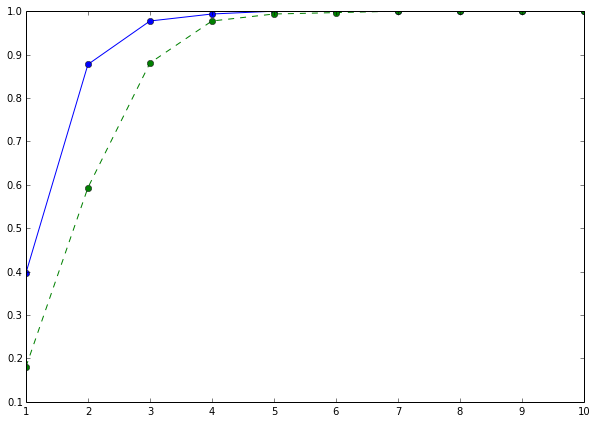

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 7))

plt.errorbar(range(1,11), within_after, marker="o")
plt.errorbar(range(1,11), within_before, linestyle="--", marker="o")

plt.show()